# Analytical Examples

This notebook supplements the work described in **[1]**, which introduces DDSG, a highly scalable function approximation technique. This algorithm was originally developed in C++ and Fortran using hybrid parallelism (OpenMP and MPI); however, the MPI parallel Python implementation presented here is intended to be more practical.

The DDSG technique is a scalable and general function approximation approach that combines Dimensional Decomposition (DD, in particular, a form known as High-Dimensional Model Representation HDMR) with adaptive Sparse Grid (SG). The DDSG class is based on Tasmanian **[2]** — a robust adaptive SG library for high-dimensional integration and interpolation. The DDSG class utilizes two levels of parallelism, both of which are MPI-based. The first level of parallelism happens along with each component function, and the second occurs inside the adaptive SG library's function evaluations. For further details on the parallelism scheme, see **[1]**.

Here, we will use DDSG to showcase its primary attributes in approximating high-dimensional functions. For a unit $d$-dimensional domain $\Omega=[0,1]^d$, the DDSG class approximates $f:\vec{x} \to \mathbb{R}^m$ for $\vec{x} \in \Omega$. For testing, we adopt the following non-smooth $d$-dimensional function,

\begin{align}
f(\vec{x}) = \prod_{i=1}^d \mathrm{exp} \left[ -15|\vec{x}_i-4/11| \right],
\end{align}

along side this test function, we also will also experiment with its _log-transform_ $\log f(\vec{x})$ and a _noisy log-transform_ variant $\log f(\vec{x})+ 0.1\vec{z}$, where $\vec{z} \sim \mathcal{N}(0,1)$. Note that for all tests, we are using function $m=1$ degrees-of-freedom. Using the DDSG function consists the following 4 steps:
1. Instantiate DDSG with the function to be approximated and the dimension of the domain, e.g., `ddsg=DDSG()` and `ddsg.init(f,d)`.
2. Set the parameters for the adaptive SG (see documentation for details), e.g., `ddsg.set_grid(l_max=10,eps_sg=1e-6)`. 
3. Set the parameters for the DD decomposition (see documentation for details), e.g., `ddsg.set_decomposition(x0=np.ones(d)/2,k_max=1)`. If `set_decomposition()` is not invoked, the DDSG class works as a wrapper for the Tasmanian library, with built-in MPI parallelism.
4. Build the approximation, e.g., `ddsg.build(verbose=1)`.

If a specific grid point evaluation is computationally demanding, we can use MPI processes to evaluate the needed grid points in parallel by setting `ddsg.sg_prl=True` (by default `ddsg.sg_prl=False`). If the number of available MPI processes exceeds the number of component functions, the extra processes are assigned in the SG computation if `ddsg.sg_prl=True`.

*References*
- **[1]** High-Dimensional Dynamic Stochastic Model Representation, A. Eftekhari, S. Scheidegger, SIAM Journal on Scientific Computing (SISC), 2022 
- **[2]** User Manual: Toolkit for Adaptive Stochastic Modeling and Non-Intrusive Approximation (TASMANIAN) M. Stoyanov, Oak Ridge National Laboratory, 2017 (see, e.g., https://github.com/ORNL/TASMANIAN)

In [1]:
import os
import sys

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from DDSG import DDSG 

# basic plot options
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', size=11)

# test functions
f_example                = lambda X: np.exp(-15*np.sum( np.abs(X-4/11) ,axis=1) )
f_example_log            = lambda X: np.log(f_example(X)+1e-14) #we add 1e-14 to keep away from log(0)
f_example_log_stochastic = lambda X: f_example_log(X) + 0.1*np.random.normal()

## 1. Basics
We want to approximate `f_example` -- an additively non-separable and non-smooth function. Here we will visualize the generated approximations using non-adaptive and adaptive SG and also with DDSG at maximum expansion order `k_max=1` and `2`. In addition, we showcase DDSG's prime attribute in the efficient representation of high-dimensional additively-separable functions. For this test, we will use `f_example_log,` which is still non-smooth but now additively separable.


As we will be visualizing these approximations, the test function will be $2$-dimensional. At such low dimensions, there is no discernible difference between SG and DDSG in terms of run-time. With this said, the visualizations and error metrics of the approximations highlight the following points: 
1) DDSG with an expansion order of one is sometimes sufficient to generate a relatively accurate representation of the function with *substantially* fewer grid points.
2) The approximation improves as the number of DDSG expansion orders increases, but it will be expensive in terms of grid points.
3) Compared to adaptive SG, DDSG reduces the number of required grid points for additively-separable functions. The primary characteristic of DDSG is that the number of required grid points for an additively-separable function increases linearly with dimension. This is in stark contrast to adaptive SG, as will be demonstrated in [4.  Performance](#4-performance).

### SG (sg_prl=False): d=2 m=1 l_max=10 ϵ_sg=4.44e-16  
### SG (sg_prl=False): d=2 m=1 l_max=10 ϵ_sg=1.00e-06  
- Building (Adaptive) Sparse Grid (1.36e-02 sec.)
### SG (sg_prl=False): d=2 m=1 l_max=10 ϵ_sg=1.00e-06  
### DDSG (sg_prl=False): d=2 m=1 k_max=1 l_max=10 ϵ_sg=1.00e-06 ϵ_ρ=4.44e-16 ϵ_η=4.44e-16 
- Expansion k=0 of 1 continue (1.41e-04 sec.)
- Expansion k=1 of 1 end ρ=7.52e-02 (1.28e-02 sec.)
### DDSG (sg_prl=False): d=2 m=1 k_max=2 l_max=10 ϵ_sg=1.00e-06 ϵ_ρ=4.44e-16 ϵ_η=4.44e-16 
- Expansion k=0 of 2 continue (8.63e-05 sec.)
- Expansion k=1 of 2 continue ρ=7.52e-02>4.44e-16 (1.23e-02 sec.)
- Expansion k=2 of 2 end ρ=2.31e-01 (1.46e-02 sec.)
### DDSG (sg_prl=False): d=2 m=1 k_max=1 l_max=10 ϵ_sg=1.00e-06 ϵ_ρ=4.44e-16 ϵ_η=4.44e-16 
- Expansion k=0 of 1 continue (8.61e-05 sec.)
- Expansion k=1 of 1 end ρ=1.02e+00 (1.06e-02 sec.)


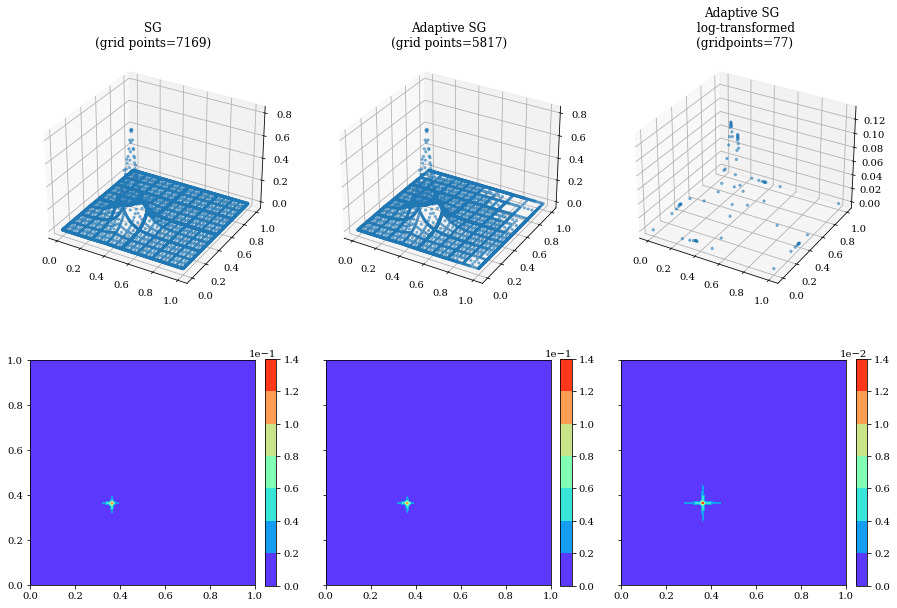

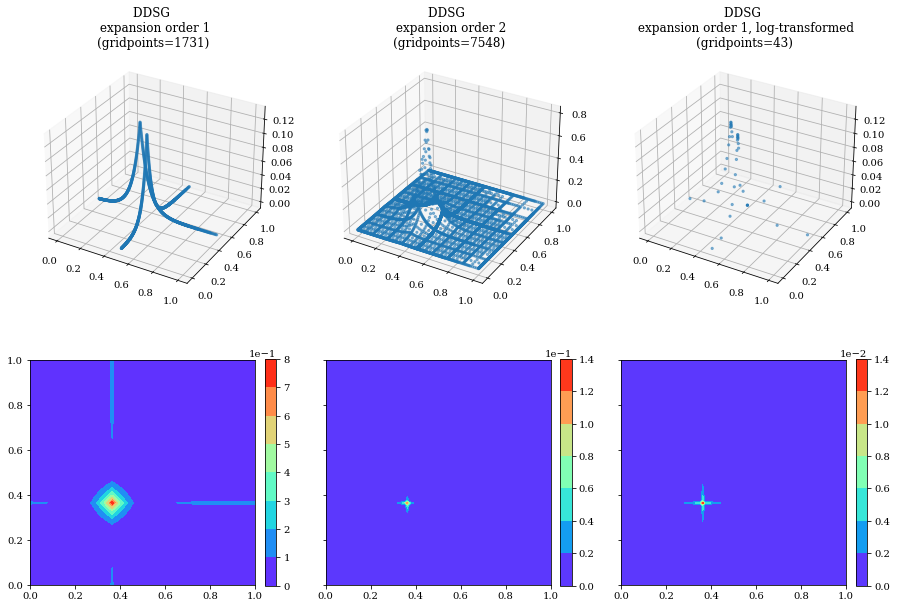

In [2]:
# genearl parameters
d        = 2
l_max    = 10
eps_sg   = 1e-6
eps_ddsg = 1e-6

domain =np.zeros(shape=(d,2))
domain[:,1]=1

# DDSG anchor point
x0 = np.ones(shape=(1,d))*0.5

# generate approximations
sg = DDSG()
sg.init(f_example,d)
sg.set_grid(domain=domain,l_max=l_max,eps_sg=0)
sg.build(verbose=1)

asg = DDSG()
asg.init(f_example,d)
asg.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
asg.build(verbose=2)

asg_log = DDSG()
asg_log.init(f_example_log,d)
asg_log.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
asg_log.build(verbose=1)

ddsg_1 = DDSG()
ddsg_1.init(f_example,d)
ddsg_1.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
ddsg_1.set_decomposition(x0=x0,k_max=1)
ddsg_1.build(verbose=2)

ddsg_2 = DDSG()
ddsg_2.init(f_example,d)
ddsg_2.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
ddsg_2.set_decomposition(x0=x0,k_max=2)
ddsg_2.build(verbose=2)

ddsg_log = DDSG()
ddsg_log.init(f_example_log,d)
ddsg_log.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
ddsg_log.set_decomposition(x0=x0,k_max=1)
ddsg_log.build(verbose=2)

#retrive grid points and values 
[x_sg  ,y_sg  ]         = sg.get_points_values()
[x_asg ,y_asg ]         = asg.get_points_values()
[x_asg_log ,y_asg_log ] = asg_log.get_points_values()

[x_ddsg_1,y_ddsg_1]     = ddsg_1.get_points_values()
[x_ddsg_2,y_ddsg_2]     = ddsg_2.get_points_values()
[x_ddsg_log,y_ddsg_log] = ddsg_log.get_points_values()

# we transform back 
y_asg_log               = np.exp(y_asg_log) 
y_ddsg_log              = np.exp(y_ddsg_log) 

#compute the errors over the entire domain over a (100x100) grid
x        = np.linspace(0, 1, 100)
y        = np.linspace(0, 1, 100)
xx, yy   = np.meshgrid(x, y)
X_sample = np.array([xx.flatten(),yy.flatten()]).T

f_example_exact = f_example(X_sample)
err_sg          = abs(f_example_exact  -              sg.eval(X_sample).reshape(-1) ).reshape((len(x),-1))
err_asg         = abs(f_example_exact  -             asg.eval(X_sample).reshape(-1) ).reshape((len(x),-1))
err_asg_log     = abs(f_example_exact  - np.exp(asg_log.eval(X_sample)).reshape(-1) ).reshape((len(x),-1))

err_ddsg_1      = abs(f_example_exact -           ddsg_1.eval(X_sample).reshape(-1) ).reshape((len(x),-1))
err_ddsg_2      = abs(f_example_exact -           ddsg_2.eval(X_sample).reshape(-1) ).reshape((len(x),-1))
err_ddsg_log    = abs(f_example_exact - np.exp(ddsg_log.eval(X_sample)).reshape(-1) ).reshape((len(x),-1))

## SG Plots
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,3,1, projection='3d')
ax.scatter(x_sg[:,0],x_sg[:,1],y_sg,marker='.',alpha=0.5)
ax.set_title('SG'+'\n(grid points='+str(x_sg.shape[0])+")")

ax = fig.add_subplot(2,3,2, projection='3d')
ax.scatter(x_asg[:,0],x_asg[:,1],y_asg,marker='.',alpha=0.5)
ax.set_title('Adaptive SG'+'\n(grid points='+str(x_asg.shape[0])+")")

ax = fig.add_subplot(2,3,3, projection='3d')
ax.scatter(x_asg_log[:,0],x_asg_log[:,1],y_asg_log,marker='.',alpha=0.5)
ax.set_title('Adaptive SG \n log-transformed'+'\n(gridpoints='+str(x_asg_log.shape[0])+")")

ax = fig.add_subplot(2,3,4,aspect='equal')
s=ax.contourf(x, y, err_sg, cmap ="rainbow")
fig.colorbar(s,fraction=0.046, pad=0.04).formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(2,3,5,aspect='equal')
s=ax.contourf(x, y, err_asg,cmap ="rainbow")
fig.colorbar(s,fraction=0.046, pad=0.04).formatter.set_powerlimits((0, 0))
ax.set_yticklabels([])

ax = fig.add_subplot(2,3,6, aspect='equal')
s=ax.contourf(x, y, err_asg_log,cmap ="rainbow")
fig.colorbar(s,fraction=0.046, pad=0.04).formatter.set_powerlimits((0, 0))
ax.set_yticklabels([])

## DDSG Plots
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2,3,1, projection='3d')
ax.scatter(x_ddsg_1[:,0],x_ddsg_1[:,1],y_ddsg_1,marker='.',alpha=0.5)
ax.set_title('DDSG \n expansion order 1'+'\n(gridpoints='+str(x_ddsg_1.shape[0])+")")

ax = fig.add_subplot(2,3,2, projection='3d')
ax.scatter(x_ddsg_2[:,0],x_ddsg_2[:,1],y_ddsg_2,marker='.',alpha=0.5)
ax.set_title('DDSG \n expansion order 2'+'\n(gridpoints='+str(x_ddsg_2.shape[0])+")")

ax = fig.add_subplot(2,3,3, projection='3d')
ax.scatter(x_ddsg_log[:,0],x_ddsg_log[:,1],y_ddsg_log,marker='.',alpha=0.5)
ax.set_title('DDSG \n expansion order 1, log-transformed'+'\n(gridpoints='+str(x_ddsg_log.shape[0])+")")

ax = fig.add_subplot(2,3,4,aspect='equal')
s=ax.contourf(x, y, err_ddsg_1,cmap ="rainbow")
fig.colorbar(s,fraction=0.046, pad=0.04).formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(2,3,5,aspect='equal')
s=ax.contourf(x, y, err_ddsg_2,cmap ="rainbow")
fig.colorbar(s,fraction=0.046, pad=0.04).formatter.set_powerlimits((0, 0))
ax.set_yticklabels([])

ax = fig.add_subplot(2,3,6, aspect='equal')
s=ax.contourf(x, y, err_ddsg_log,cmap ="rainbow")
fig.colorbar(s,fraction=0.046, pad=0.04).formatter.set_powerlimits((0, 0))
ax.set_yticklabels([])

plt.show()

### 2. Additive Separability 
The computational performance and approximation error of the DDSG algorithm is dependent on both the expansion order and the function being approximated. With this said, for a $d$-dimensional function, we may truncate the maximum expansion order to $\mathcal{k}<d$ without inducing additional errors; this depends on the degree of additive-separability of the function. This property of DDSG is illustrated here with a $4$-dimensional polynomial of degrees $1,2$, and $3$.

*Note*: 
- The `.benchmark()` method can be called to benchmark the error, run-time, number of grid points, and other attributes; see the benchmark docstring for further details.  
- Error-Max: The maximum value of the absolute difference between the interpolated and true value of the function for $N=1000$ random samples. 
- Error-L2: The square root of the sum of squared difference  between the interpolated and true value of the function for $N=1000$ random samples. 

##########################
#F1 - 1st order seperable
##########################
### DDSG (sg_prl=False): d=4 m=1 k_max=1 l_max=10 ϵ_sg=1.00e-06 ϵ_ρ=4.44e-16 ϵ_η=4.44e-16 
- Expansion k=0 of 1 continue (8.32e-05 sec.)
- Expansion k=1 of 1 end ρ=2.75e-03 (1.13e-02 sec.)
### DDSG (sg_prl=False): d=4 m=1 k_max=2 l_max=10 ϵ_sg=1.00e-06 ϵ_ρ=4.44e-16 ϵ_η=4.44e-16 
- Expansion k=0 of 2 continue (6.75e-05 sec.)
- Expansion k=1 of 2 continue ρ=7.43e-04>4.44e-16 (3.88e-03 sec.)
- Expansion k=2 of 2 truncated ρ=0.00e+00≤4.44e-16 (4.69e-03 sec.)
### DDSG (sg_prl=False): d=4 m=1 k_max=3 l_max=10 ϵ_sg=1.00e-06 ϵ_ρ=4.44e-16 ϵ_η=4.44e-16 
- Expansion k=0 of 3 continue (5.98e-05 sec.)
- Expansion k=1 of 3 continue ρ=8.42e-03>4.44e-16 (6.29e-03 sec.)
- Expansion k=2 of 3 truncated ρ=0.00e+00≤4.44e-16 (4.37e-03 sec.)
### DDSG (sg_prl=False): d=4 m=1 k_max=4 l_max=10 ϵ_sg=1.00e-06 ϵ_ρ=4.44e-16 ϵ_η=4.44e-16 
- Expansion k=0 of 4 continue (6.84e-05 sec.)
- Expansion k=1 of 4 continue ρ=6.95e-03>4.44e-16 (3.4

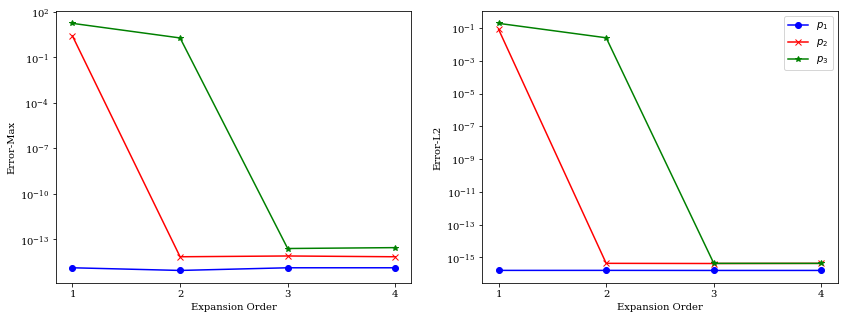

In [3]:
# polynomial of degree 1,2 and 3
f_poly1 = lambda x: np.power(np.sum(x,axis=1),1.0)
f_poly2 = lambda x: np.power(np.sum(x,axis=1),2.0)
f_poly3 = lambda x: np.power(np.sum(x,axis=1),3.0)

d = 4
domain =np.zeros(shape=(d,2))
domain[:,1]=1
x0 = np.ones(shape=(1,d))*0.5

# Generate DDSG object 
ddsg_1 = DDSG()
ddsg_1.init(f_poly1,d)
ddsg_1.set_grid(domain=domain,l_max=10,eps_sg=1e-6,grid_order=3)

ddsg_2 = DDSG()
ddsg_2.init(f_poly2,d)
ddsg_2.set_grid(domain=domain,l_max=10,eps_sg=1e-6,grid_order=3)

ddsg_3 = DDSG()
ddsg_3.init(f_poly3,d)
ddsg_3.set_grid(domain=domain,l_max=10,eps_sg=1e-6,grid_order=3)

k_max_set = [1,2,3,4]
print('##########################')
print('#F1 - 1st order seperable')
print('##########################')
err_max_ddsg_1     = np.zeros(len(k_max_set))
err_l2_ddsg_1 = np.zeros(len(k_max_set))
for i,k_max in enumerate(k_max_set):
    ddsg_1.set_decomposition(x0=x0,k_max=k_max)  
    [err_max_ddsg_1[i],err_l2_ddsg_1[i],*_]  = ddsg_1.benchmark(N=1000,verbose=2)
    
print('##########################')
print('#F2 - 2nd order seperable')
print('##########################')
err_max_ddsg_2 = np.zeros(len(k_max_set))
err_l2_ddsg_2  = np.zeros(len(k_max_set))
for i,k_max in enumerate(k_max_set):
    ddsg_2.set_decomposition(x0=x0,k_max=k_max)  
    [err_max_ddsg_2[i],err_l2_ddsg_2[i],*_]  = ddsg_2.benchmark(N=1000,verbose=2)
    
print('##########################')
print('#F3 - 3rd order seperable')
print('##########################')
err_max_ddsg_3     = np.zeros(len(k_max_set))
err_l2_ddsg_3 = np.zeros(len(k_max_set))
for i,k_max in enumerate(k_max_set):
    ddsg_3.set_decomposition(x0=x0,k_max=k_max)  
    [err_max_ddsg_3[i],err_l2_ddsg_3[i],*_]  = ddsg_3.benchmark(N=1000,verbose=2) 


# Plot
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,2,1)
ax.plot(k_max_set,err_max_ddsg_1,'-o', color='blue')
ax.plot(k_max_set,err_max_ddsg_2,'-x', color='red')
ax.plot(k_max_set,err_max_ddsg_3,'-*', color='green')
ax.set_yscale('log')
ax.set_ylabel('Error-Max')
ax.set_xlabel('Expansion Order')
ax.set_xticks([1,2,3,4])

ax = fig.add_subplot(1,2,2)
ax.plot(k_max_set,err_l2_ddsg_1,'-o', color='blue')
ax.plot(k_max_set,err_l2_ddsg_2,'-x', color='red')
ax.plot(k_max_set,err_l2_ddsg_3,'-*', color='green')
ax.set_yscale('log')
ax.set_ylabel('Error-L2')
ax.set_xlabel('Expansion Order')
ax.set_xticks([1,2,3,4])

ax.legend(['$p_1$', '$p_2$', '$p_3$'])

plt.show()

### 4. Performance
To continue the analysis from Section [1. Basics](#1-basics), we now look at the run-time performance and approximation errors for high-dimensional functions from $2$ to $10$-dimensions, increasing in increments of $2$. For these examples, we use the stochastic test function `f_example_log_stochastic`. Notice that the DDSG expansion order is automatically truncated based on the adaptivity criteria used in the algorithm (see **[1]** for further details). Even though we have set the DDSG maximum expansion order to $2$, it will be (most likely) truncated at $1$. If the `f_example_log` was used, we would be sure that it would be truncated at expansion order $1$. 

The significant observation is the exponential difference in the number of grid points and run-times between adaptive SG and DDSG as dimension increases.

In [4]:
# Run-time and error performance for SG and DDSG 
# for [2,4,6,4,8,10]-diemnsional function
from tabulate import tabulate

T_sg   = []
T_ddsg = []    
    
eps_ddsg = 1e-6
eps_sg   = 1e-6
l_max    = 6
k_max    = 2

for d in [2,4,6,8,10]:
    
    domain =np.zeros(shape=(d,2))
    domain[:,1]=1

    print('### Dimension:', d) 
    asg = DDSG()
    asg.init(f_example_log_stochastic,d)
    asg.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
    [err_max,err_l2,num_grid_points,num_func,t_build,t_eval,t_orical]  = asg.benchmark(N=1000,verbose=2)
    T_sg.append( [d,err_max,err_l2,num_grid_points,num_func,t_build,t_eval,t_orical])

    x0=np.ones(shape=(1,d))/2
    ddsg = DDSG()
    ddsg.init(f_example_log_stochastic,d)
    ddsg.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
    ddsg.set_decomposition(x0,k_max=k_max,eps_rho=eps_ddsg, eps_eta=eps_ddsg)
    [err_max,err_l2,num_grid_points,num_func,t_build,t_eval,t_orical]  = ddsg.benchmark(N=1000,verbose=2)  
    T_ddsg.append( [d,err_max,err_l2,num_grid_points,num_func,t_build,t_eval,t_orical])
    
headers = ['Dim','Error-Max','Error-L2','#Grid Points','#Comp. Func.','Time-Build','Time-Eval','Time-Orical']

print('\n### Adaptive Sparse Grid')
print(tabulate(T_sg,headers=headers))

print('\n### DDSG with Adaptive Sparse Grid')
print(tabulate(T_ddsg,headers=headers))

### Dimension: 2
### SG (sg_prl=False): d=2 m=1 l_max=6 ϵ_sg=1.00e-06  
- Building (Adaptive) Sparse Grid (4.56e-03 sec.)
### DDSG (sg_prl=False): d=2 m=1 k_max=2 l_max=6 ϵ_sg=1.00e-06 ϵ_ρ=1.00e-06 ϵ_η=1.00e-06 
- Expansion k=0 of 2 continue (1.25e-04 sec.)
- Expansion k=1 of 2 continue ρ=9.34e-01>1.00e-06 (7.93e-03 sec.)
- Expansion k=2 of 2 end ρ=7.91e-02 (4.70e-03 sec.)
### Dimension: 4
### SG (sg_prl=False): d=4 m=1 l_max=6 ϵ_sg=1.00e-06  
- Building (Adaptive) Sparse Grid (1.13e-02 sec.)
### DDSG (sg_prl=False): d=4 m=1 k_max=2 l_max=6 ϵ_sg=1.00e-06 ϵ_ρ=1.00e-06 ϵ_η=1.00e-06 
- Expansion k=0 of 2 continue (1.10e-04 sec.)
- Expansion k=1 of 2 continue ρ=9.27e-01>1.00e-06 (1.13e-02 sec.)
- Expansion k=2 of 2 end ρ=4.16e-01 (2.21e-02 sec.)
### Dimension: 6
### SG (sg_prl=False): d=6 m=1 l_max=6 ϵ_sg=1.00e-06  
- Building (Adaptive) Sparse Grid (6.65e-02 sec.)
### DDSG (sg_prl=False): d=6 m=1 k_max=2 l_max=6 ϵ_sg=1.00e-06 ϵ_ρ=1.00e-06 ϵ_η=1.00e-06 
- Expansion k=0 of 2 continue (1.22e

### 4. Strong-Scaling

To run DDSG in parallel, the script must be executed using `mpirun`; for example, to run the script with four processes, use the command `mpirun -—bind-to core -np 4 python3 script.py`. The `-—bind-to core` flag ensures that the processes are linked to the machine's cores. 

The parallel scalability of the DDSG class is demonstrated in the following example. Three tests are run at varying numbers of processing for a fixed $10$-dimensional function at maximum refinement level of $8$. The first set of tests are run with SG only (we do this by not calling the `ddsg.set_decomposition` method ), and the remaining two are with DDSG at expansion orders $1$ and $2$. Here we assume a computationally expensive function, that is, one for which every function evaluation takes a relatively long time to evaluate. As such we set `ddsg.sg_prl=True`. Refer to the testing script `unit_test.py` for further details. The command `mpirun —bind-to core -np 16 python3 unit test.py 10 8 1`, for example, runs the unit test for a $10$ dimensional function with maximum refinement level and expansion order of $8$ and $1$, respectively.

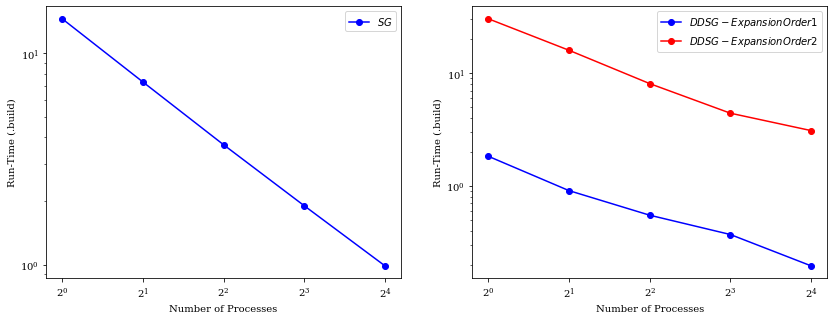

In [5]:
# number of process
n_proc=[1,2,4,8,16]

# Test run for SG via following commands
#mpirun --bind-to core -np 1  python3 unit_test.py 10 8 -1
#mpirun --bind-to core -np 2  python3 unit_test.py 10 8 -1
#mpirun --bind-to core -np 4  python3 unit_test.py 10 8 -1
#mpirun --bind-to core -np 8  python3 unit_test.py 10 8 -1
#mpirun --bind-to core -np 16  python3 unit_test.py 10 8 -1
sg_build_runtime    =[14.6034,7.33083,3.69616,1.89946,0.986348]

# Test run for DDSG expansion order 1 via following commands
#mpirun --bind-to core -np 1  python3 unit_test.py 10 8 1
#mpirun --bind-to core -np 2  python3 unit_test.py 10 8 1
#mpirun --bind-to core -np 4  python3 unit_test.py 10 8 1
#mpirun --bind-to core -np 8  python3 unit_test.py 10 8 1
#mpirun --bind-to core -np 16  python3 unit_test.py 10 8 1
ddsg_1_build_runtime=[1.83019,0.906807,0.548711,0.369751,0.194929]


# Test run for DDSG expansion order 2 via following commands
#mpirun --bind-to core -np 1  python3 unit_test.py 10 8 2
#mpirun --bind-to core -np 2  python3 unit_test.py 10 8 2
#mpirun --bind-to core -np 4  python3 unit_test.py 10 8 2
#mpirun --bind-to core -np 8  python3 unit_test.py 10 8 2
#mpirun --bind-to core -np 16  python3 unit_test.py 10 8 2
ddsg_2_build_runtime=[30.3874,15.9602,8.07814,4.4112,3.0919]

# Plot
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,2,1)
ax.plot(n_proc,sg_build_runtime,'-o', color='blue')
ax.set_ylabel('Run-Time (.build)')
ax.set_xlabel('Number of Processes')
ax.set_xticks(n_proc)
ax.set_yscale('log')
ax.set_xscale('log',base=2)
ax.legend(['$SG$'])

ax = fig.add_subplot(1,2,2)
ax.plot(n_proc,ddsg_1_build_runtime,'-o', color='blue')
ax.plot(n_proc,ddsg_2_build_runtime,'-o', color='red')
ax.set_ylabel('Run-Time (.build)')
ax.set_xlabel('Number of Processes')
ax.set_xticks(n_proc)
ax.set_yscale('log')
ax.set_xscale('log',base=2)
ax.legend(['$DDSG-Expansion Order 1$','$DDSG-Expansion Order 2$'])
plt.show()